In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import simulate
#import inference
%matplotlib inline

np.random.seed(1)

In [2]:
# parameter setting:
n = 100    # number of variables
g = 2.0    # coupling variability parameter

w0 = np.random.normal(0.0,g/np.sqrt(n),size=(n,n))

In [3]:
# sparse coupling
sp = 0.7
for i in range(n):
    for j in range(n):
        if np.random.rand() < sp: 
            w0[i,j] = 0.

The heat map of the actual coupling matrix `w0` is plotted:

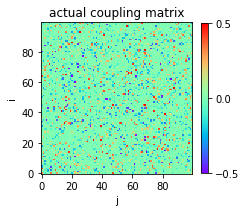

In [4]:
plt.figure(figsize=(3,3))
plt.title('actual coupling matrix')
plt.imshow(w0,cmap='rainbow',origin='lower')
plt.xlabel('j')
plt.ylabel('i')
plt.clim(-0.5,0.5)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.5,0,0.5])
plt.show()

Using the function `simulate.generate_data`, we then generate a time series of variable states according to the kinetic Ising model with a data length $L = 2000$.

In [5]:
l = 100
s = simulate.generate_data(w0,l)

In [6]:
from scipy import linalg
from sklearn.linear_model import ElasticNet

def fit(x,y,niter_max=100,lamda=0.5,alpha=0.2,l1_ratio=0.5):    
    n = x.shape[1]
    
    x_av = np.mean(x,axis=0)
    dx = x - x_av
    c = np.cov(dx,rowvar=False,bias=True)
    
    # 2019.05.14: Ridge Regression
    #c += lamda*np.identity(c.shape[0])    
    #c_inv = linalg.inv(c)
    
    # 2019.05.14: Elastic Net
    regr = ElasticNet(alpha=0.2,l1_ratio=0.5)

    # initial values
    h0 = 0.
    w = np.random.normal(0.0,1./np.sqrt(n),size=(n))
    
    cost = np.full(niter_max,100.)
    for iloop in range(niter_max):
        h = h0 + x.dot(w)
        y_model = np.tanh(h)    

        # stopping criterion
        cost[iloop] = ((y[:]-y_model[:])**2).mean()
        if iloop>0 and cost[iloop] >= cost[iloop-1]: break

        # update local field
        t = h!=0    
        h[t] *= y[t]/y_model[t]
        h[~t] = y[~t]

        # find w from h    
        #h_av = h.mean()
        #dh = h - h_av 
        #dhdx = dh[:,np.newaxis]*dx[:,:]

        #dhdx_av = dhdx.mean(axis=0)
        #w = c_inv.dot(dhdx_av)
        #h0 = h_av - x_av.dot(w)
        
        regr.fit(x, h)
        w = regr.coef_
        h0 = regr.intercept_
                
    return h0,w

In [12]:
n = s.shape[1]

h0 = np.zeros(n)
w = np.zeros((n,n))

for i0 in range(n):
    x = s[:-1,:]
    y = s[1:,i0]    
    #h0[i0],w[i0,:] = inference.fit(x,y)
    h0[i0],w[i0,:] = fit(x,y,niter_max=100,lamda=0.1,alpha=0.02,l1_ratio=0.)

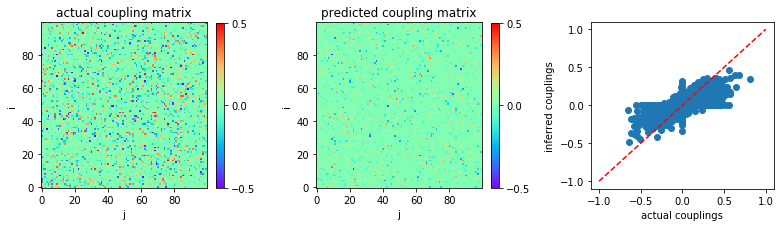

In [13]:
plt.figure(figsize=(11,3.2))

plt.subplot2grid((1,3),(0,0))
plt.title('actual coupling matrix')
plt.imshow(w0,cmap='rainbow',origin='lower')
plt.xlabel('j')
plt.ylabel('i')
plt.clim(-0.5,0.5)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.5,0,0.5])

plt.subplot2grid((1,3),(0,1))
plt.title('predicted coupling matrix')
plt.imshow(w,cmap='rainbow',origin='lower')
plt.xlabel('j')
plt.ylabel('i')
plt.clim(-0.5,0.5)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.5,0,0.5])

plt.subplot2grid((1,3),(0,2))
plt.plot([-1,1],[-1,1],'r--')
plt.scatter(w0,w)
plt.xlabel('actual couplings')
plt.ylabel('inferred couplings')

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.show()

The inference accuracy is measured by mean square error between actual couplings and inferred couplings: MSE = $\frac{1}{N^{2}} \sum_{i,j=1}^N (W_{ij} - W_{ij}^{\text{actual}})$ 

In [9]:
MSE = ((w0-w)**2).mean()
print(MSE)

0.008594116761793735
